In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
import dtreeviz

from tqdm import tqdm
import warnings
from pprint import pprint

warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv("./data/augmented_data.csv")

In [4]:
data.nunique()

period                     5
minute                   139
second                    60
possession               290
duration               77925
season_id                 41
match_id                3312
timestamp              82726
team                     288
play_pattern               9
position                  25
player_type                5
location_x               635
location_x_distance      635
location_y               701
location_y_distance      471
technique                  7
body_part                  4
type                       5
is_penalty                 2
is_header                  2
first_time                 2
open_goal                  2
one_on_one                 2
aerial_won                 2
follows_dribble            2
under_pressure             2
pass_duration          11897
pass_angle             10504
pass_type                  8
pass_height                4
pass_length             9918
num_passes                13
defenders_3m_radius       10
defenders_tria

In [5]:
# Use mutual_info classification to check which features yield the most information about the target variable
data_copy = data.copy()
X = data_copy.drop(["statsbomb_xg", "is_goal", "end_location_x", "end_location_y", "shot_angle", "duration", "season_id", "match_id", "timestamp", "team", "xg_so_far", "location_x", "location_y", "game_state", "body_part", "defenders_3m_radius", "under_pressure", "goal_distance", "play_pattern", "technique", "position", "body_part", "type", "pass_type", "pass_height"], axis=1)
mutual_info = mutual_info_classif(X, data["is_goal"])
mutual_info = pd.Series(mutual_info)
mutual_info.index = X.columns
mutual_info.sort_values(ascending=False)

distance_to_goalie     0.058079
shooting_range         0.052155
best_distance          0.050371
defenders_triangle     0.039254
location_x_distance    0.032021
goalkeeper_x           0.029785
goalkeeper_y           0.021827
location_y_distance    0.021401
is_penalty             0.015835
own_past_minute        0.012070
open_goal              0.011075
pass_length            0.010857
pass_duration          0.010247
period                 0.008601
past_minute            0.007561
good_foot              0.006471
num_passes             0.005984
player_type            0.005118
was_leading            0.004250
first_time             0.004068
pass_angle             0.003545
possession             0.002912
one_on_one             0.002828
own_past_15            0.002505
minute                 0.002447
is_header              0.002168
past_15                0.000655
shots_so_far           0.000592
aerial_won             0.000526
is_extra_time          0.000381
follows_dribble        0.000331
second  

In [6]:
# drop redundant features
data.drop(["location_x", "location_y", "game_state", "body_part", "defenders_3m_radius", "under_pressure", "player_type", "best_distance"], axis=1, inplace=True)
# drop features that leak target information
data.drop(["end_location_x", "end_location_y", "shot_angle", "duration", "season_id", "match_id", "timestamp", "team", "xg_so_far"], axis=1, inplace=True)
# drop low information features
data.drop(["period", "minute", "second", "possession", "aerial_won", "follows_dribble", "num_passes", "pass_length", "pass_duration", "pass_height", "pass_type", "pass_angle", "shots_so_far", "past_minute", "past_15", "own_past_minute", "own_past_15"], axis=1, inplace=True)
# drop penalties
data = data[data["is_penalty"] == False]

In [7]:
data.nunique()

play_pattern               9
position                  25
location_x_distance      635
location_y_distance      471
technique                  7
type                       4
is_penalty                 1
is_header                  2
first_time                 2
open_goal                  2
one_on_one                 2
defenders_triangle        12
goalkeeper_x             258
goalkeeper_y             355
distance_to_goalie     45441
shooting_range         43788
goal_distance          36856
statsbomb_xg           82416
is_goal                    2
good_foot                  2
was_leading                3
is_extra_time              2
dtype: int64

In [8]:
# one-hot encode the categorical data
encoded_data = data
for column_name in ["play_pattern", "technique", "type", "position"]:
    one_hot_encoded = pd.get_dummies(encoded_data[column_name], prefix=column_name)
    encoded_data = encoded_data.drop(column_name, axis=1)
    encoded_data = pd.concat([encoded_data, one_hot_encoded], axis=1)
data = encoded_data

In [9]:
data = data.dropna()
data.replace([np.inf, -np.inf], 0, inplace=True)

In [10]:
y1 = data["statsbomb_xg"]
y2 = data["is_goal"]
X = data.drop(["statsbomb_xg", "is_goal"], axis=1)

In [11]:
def preprocess_continuous(X, y):

    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

    return X_train, X_test, y_train, y_test

In [12]:
def preprocess_classifier(X, y):

    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

    X_train, y_train = SMOTE(sampling_strategy=0.2).fit_resample(X_train, y_train)

    return X_train, X_test, y_train, y_test

In [13]:
def calculate_errors(results_test, results_pred, name):
    mae = mean_absolute_error(results_test, results_pred)
    rmse = root_mean_squared_error(results_test, results_pred)
    r2 = r2_score(results_test, results_pred)
    print(f"\n{name}")
    print("Mean Absolute Error:", mae)
    print("Root Mean Squared Error:", rmse)
    print("R-squared (R2 Score):", r2)

In [14]:
def calculate_stats(results_test, results_pred, name):
    cm = confusion_matrix(results_test, results_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not a goal", "Goal"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix ({name})')
    plt.show()

    print(f"\n{name}")
    accuracy = accuracy_score(results_test, results_pred)
    precision = precision_score(results_test, results_pred)
    recall = recall_score(results_test, results_pred)
    f1 = f1_score(results_test, results_pred)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1:", f1)

In [15]:
def linear_regression():
    linear_r = LinearRegression()
    linear_r.fit(X_train, y_train)
    y_pred = linear_r.predict(X_test)

    calculate_errors(y_test, y_pred, "Linear Regression")

    return y_pred

In [16]:
def logistic_regression():
    logistic_r = LogisticRegression()
    logistic_r.fit(X_train, y_train)
    y_pred = logistic_r.predict(X_test)

    calculate_stats(y_test, y_pred, "Logistic Regression")

    return logistic_r.predict_proba(X_test)

In [17]:
def decision_tree():
    dt = DecisionTreeClassifier(criterion="gini", max_depth=12, max_leaf_nodes=100, min_samples_split=100)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)

    calculate_stats(y_test, y_pred, "Decision Tree")

    viz_model = dtreeviz.model(dt,
                           X_train=X_train, y_train=y_train,
                           feature_names=X.columns, target_name="is_goal", class_names=["Not a goal", "Goal"])

    return dt.predict_proba(X_test), viz_model

In [18]:
def gradient_boosted_tree():
    gbt = GradientBoostingClassifier(learning_rate=0.09, max_depth=8, min_samples_split=100, n_estimators=250, max_features=None)
    gbt.fit(X_train, y_train)
    y_pred = gbt.predict(X_test)

    calculate_stats(y_test, y_pred, "Gradient Boosted Tree")

    return gbt.predict_proba(X_test)

In [19]:
X_train, X_test, y_train, y_test = preprocess_continuous(X, y1)
lr_xg = linear_regression()


Linear Regression
Mean Absolute Error: 0.038821175312061744
Root Mean Squared Error: 0.0620059014869433
R-squared (R2 Score): 0.7489206097362875


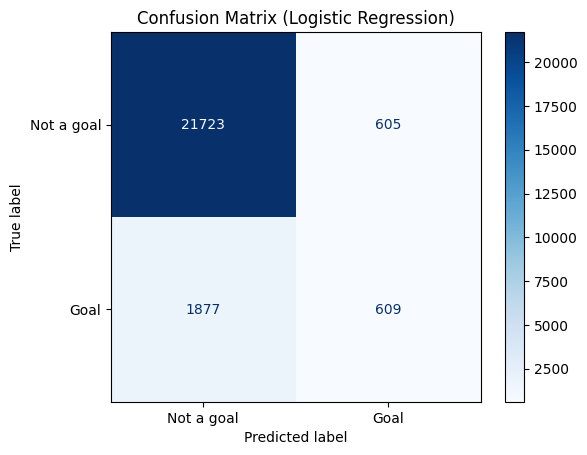


Logistic Regression
Accuracy: 0.8999758201015555
Precision: 0.5016474464579901
Recall: 0.24497184231697505
F1: 0.3291891891891892


In [20]:
X_train, X_test, y_train, y_test = preprocess_classifier(X, y2)
lor_xg = logistic_regression()

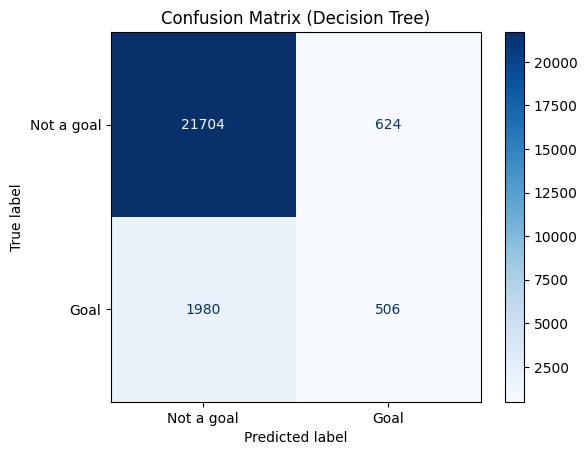


Decision Tree
Accuracy: 0.8950592407511888
Precision: 0.44778761061946903
Recall: 0.20353982300884957
F1: 0.27986725663716816


In [21]:
dt_xg, viz = decision_tree()

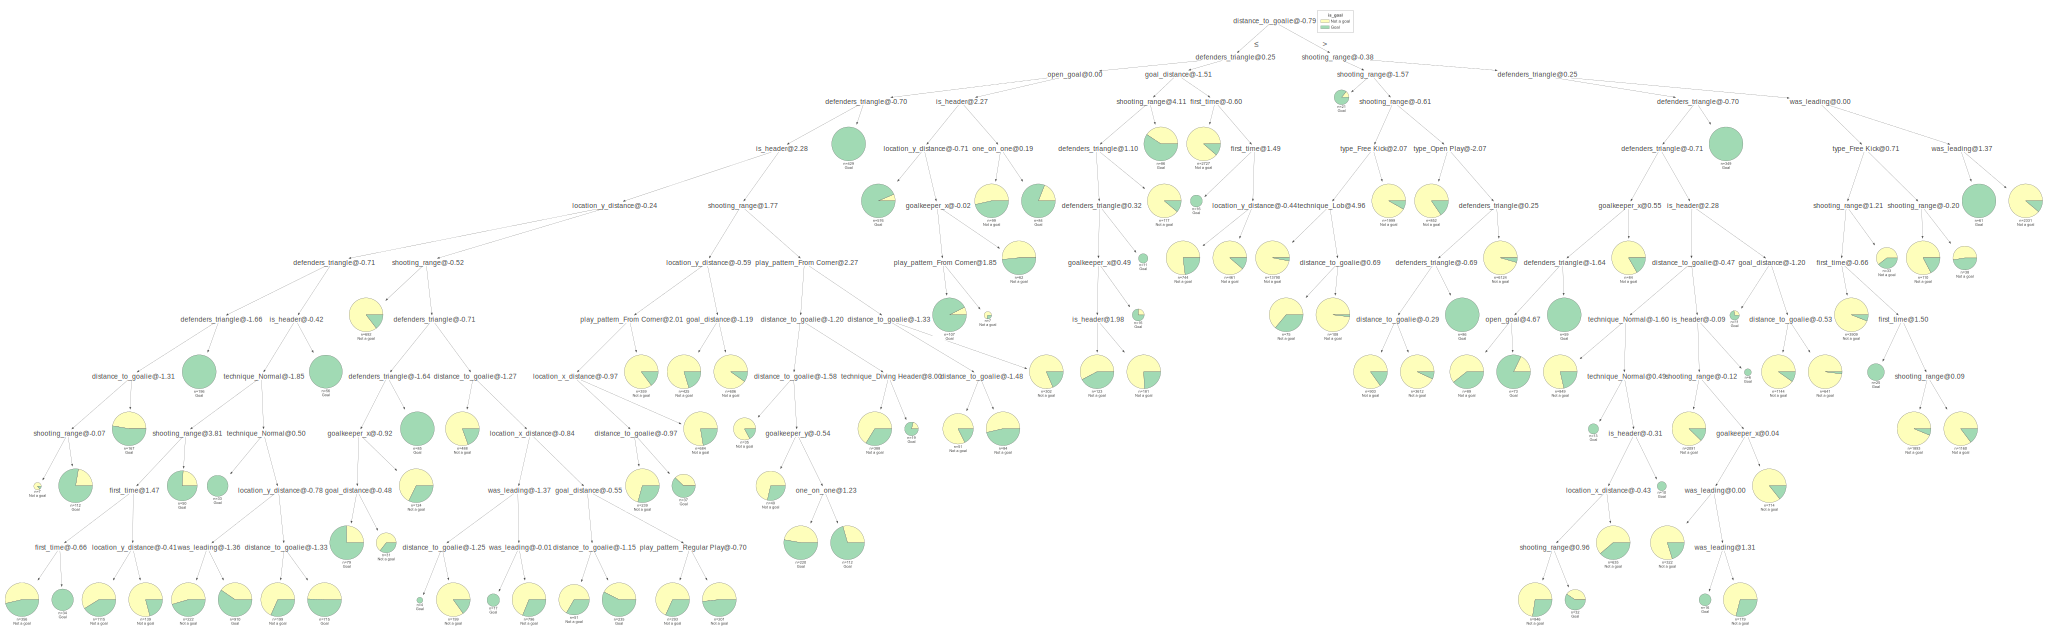

In [22]:
viz.view(fancy=False)

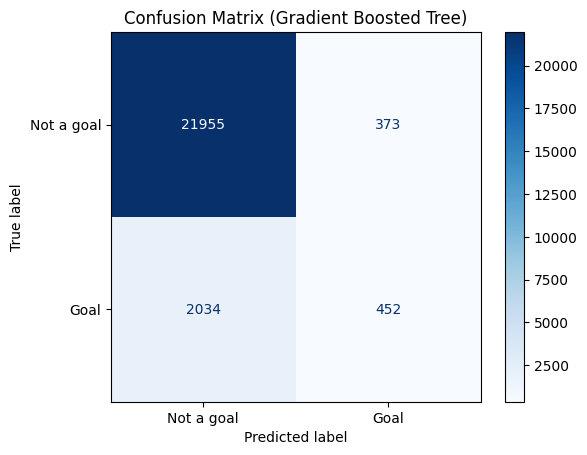


Gradient Boosted Tree
Accuracy: 0.9029983074071088
Precision: 0.5478787878787879
Recall: 0.18181818181818182
F1: 0.27302929628511025


In [23]:
gbt_xg = gradient_boosted_tree()

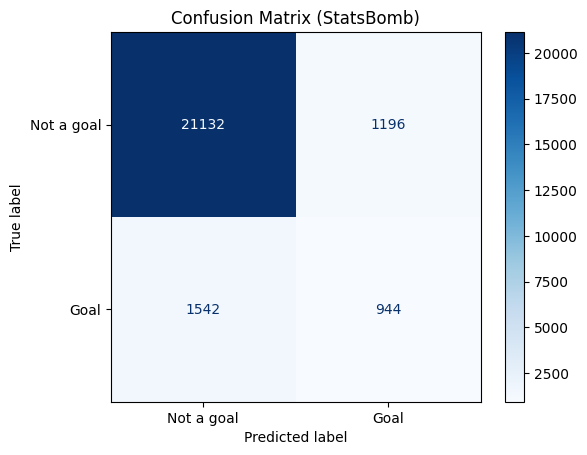


StatsBomb
Accuracy: 0.8896590634319336
Precision: 0.4411214953271028
Recall: 0.3797264682220434
F1: 0.40812797233030695


In [24]:
# empirically, the statsbomb predictions maximise f1 score at threshold=0.15, precision at threshold=1, recall at threshold=0, and accuracy at threshold=20
_, X_temp, _, sb_xg = preprocess_continuous(X, y1)
sb_pred = sb_xg.apply(lambda x: math.ceil(x-0.25))
calculate_stats(y_test, sb_pred, "StatsBomb")

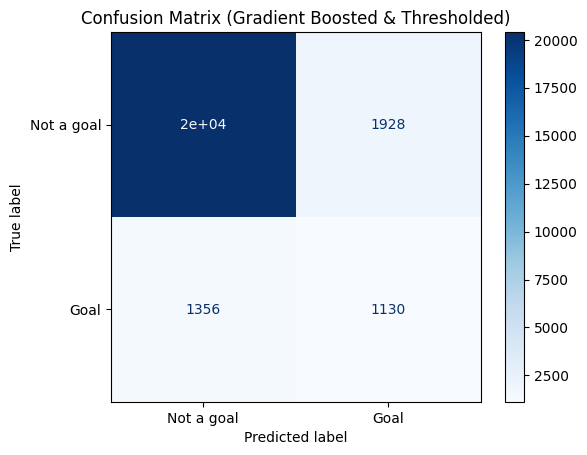


Gradient Boosted & Thresholded
Accuracy: 0.8676553558475054
Precision: 0.3695225637671681
Recall: 0.45454545454545453
F1: 0.40764790764790765


In [25]:
# empirically, the statsbomb predictions maximise f1 score at threshold=0.15, precision at threshold=1, recall at threshold=0, and accuracy at threshold=20
gbt_pred = [math.ceil(x[1]-0.25) for x in gbt_xg]
calculate_stats(y_test, gbt_pred, "Gradient Boosted & Thresholded")

In [26]:
df = pd.DataFrame({"lr_xg": lr_xg, "lor_xg": [x[1] for x in lor_xg], "dt_xg": [x[1] for x in dt_xg], "gbt_xg": [x[1] for x in gbt_xg], "sxg": sb_xg})
pprint(pd.DataFrame(np.corrcoef(np.asarray(df["lr_xg"]), np.asarray(df["sxg"]))))
pprint(pd.DataFrame(np.corrcoef(np.asarray(df["lor_xg"]), np.asarray(df["sxg"]))))
pprint(pd.DataFrame(np.corrcoef(np.asarray(df["dt_xg"]), np.asarray(df["sxg"]))))
pprint(pd.DataFrame(np.corrcoef(np.asarray(df["gbt_xg"]), np.asarray(df["sxg"]))))

         0        1
0  1.00000  0.86548
1  0.86548  1.00000
         0        1
0  1.00000  0.88794
1  0.88794  1.00000
          0         1
0  1.000000  0.838595
1  0.838595  1.000000
          0         1
0  1.000000  0.855022
1  0.855022  1.000000


In [27]:
diff = gbt_pred - y_test
data_copy.iloc[diff[diff == -1].index].sort_values(by=["statsbomb_xg"])

,period,minute,second,possession,duration,season_id,match_id,timestamp,team,play_pattern,...,good_foot,shots_so_far,xg_so_far,game_state,was_leading,past_minute,past_15,own_past_minute,own_past_15,is_extra_time
41198,2.0,81.0,4.0,151.0,2.456509,2021/2022,3817886.0,00:36:04.314,Kerala Blasters,From Throw In,...,True,13,0.877704,1.0,1,1.0,2.0,1.0,2.0,False
7482,1.0,34.0,57.0,93.0,3.394190,2018/2019,19810.0,00:34:57.530,Bristol City WFC,From Free Kick,...,False,2,0.111244,-1.0,-1,2.0,4.0,1.0,4.0,False
77163,1.0,47.0,11.0,107.0,1.816030,2015/2016,3900538.0,00:47:11.667,Guingamp,From Free Kick,...,False,4,0.204867,-1.0,-1,1.0,1.0,1.0,1.0,False
75940,1.0,49.0,18.0,90.0,2.868910,2023,3893829.0,00:49:18.772,France Women's,From Corner,...,True,18,2.147718,2.0,1,1.0,5.0,1.0,2.0,False
62636,2.0,63.0,1.0,165.0,1.796333,2015/2016,3879742.0,00:18:01.574,AC Milan,Regular Play,...,True,9,0.485998,1.0,1,1.0,6.0,1.0,7.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29736,2.0,69.0,51.0,147.0,1.171896,2015/2016,3754241.0,00:24:51.169,Arsenal,From Corner,...,False,9,1.268743,-1.0,-1,1.0,5.0,1.0,2.0,False
51817,2.0,47.0,15.0,105.0,0.714031,2015/2016,3829483.0,00:02:15.187,Paris Saint-Germain,From Throw In,...,False,7,0.501201,-1.0,-1,2.0,2.0,1.0,1.0,False
1775,1.0,39.0,3.0,72.0,0.320000,2018,7555.0,00:39:03.340,Colombia,From Corner,...,False,2,0.023627,0.0,0,1.0,2.0,1.0,3.0,False
42021,1.0,44.0,43.0,86.0,0.456438,2015/2016,3825576.0,00:44:43.437,Valencia,From Corner,...,True,1,0.038833,-1.0,-1,1.0,3.0,1.0,2.0,False


In [28]:
diff_sb = sb_pred - y_test
data_copy.iloc[diff_sb[diff_sb == -1].index].sort_values(by=["statsbomb_xg"])

,period,minute,second,possession,duration,season_id,match_id,timestamp,team,play_pattern,...,good_foot,shots_so_far,xg_so_far,game_state,was_leading,past_minute,past_15,own_past_minute,own_past_15,is_extra_time
75341,1.0,3.0,35.0,10.0,2.117102,2023,3893807.0,00:03:35.731,Republic of Ireland Women's,From Corner,...,True,2,0.449885,0.0,0,3.0,4.0,1.0,2.0,False
41198,2.0,81.0,4.0,151.0,2.456509,2021/2022,3817886.0,00:36:04.314,Kerala Blasters,From Throw In,...,True,13,0.877704,1.0,1,1.0,2.0,1.0,2.0,False
7482,1.0,34.0,57.0,93.0,3.394190,2018/2019,19810.0,00:34:57.530,Bristol City WFC,From Free Kick,...,False,2,0.111244,-1.0,-1,2.0,4.0,1.0,4.0,False
77163,1.0,47.0,11.0,107.0,1.816030,2015/2016,3900538.0,00:47:11.667,Guingamp,From Free Kick,...,False,4,0.204867,-1.0,-1,1.0,1.0,1.0,1.0,False
75940,1.0,49.0,18.0,90.0,2.868910,2023,3893829.0,00:49:18.772,France Women's,From Corner,...,True,18,2.147718,2.0,1,1.0,5.0,1.0,2.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68052,2.0,57.0,42.0,134.0,1.159092,2015/2016,3890301.0,00:12:42.473,Borussia Dortmund,Regular Play,...,False,11,1.306002,1.0,1,1.0,4.0,1.0,2.0,False
67019,2.0,72.0,14.0,138.0,0.461844,2015/2016,3890259.0,00:27:14.850,Bayern Munich,From Counter,...,False,17,1.879459,3.0,1,2.0,8.0,1.0,1.0,False
6419,1.0,12.0,30.0,29.0,0.893162,2018/2019,19767.0,00:12:30.099,Everton LFC,From Counter,...,False,0,0.000000,0.0,0,1.0,6.0,1.0,3.0,False
56935,2.0,87.0,24.0,177.0,0.720786,2015/2016,3878598.0,00:42:24.506,Palermo,Regular Play,...,False,11,0.890094,0.0,0,1.0,5.0,2.0,3.0,False


In [29]:
_, data_copy_test, _, gbt_xg_test = train_test_split(data_copy[data_copy["is_penalty"] == False], y2, test_size=0.3, random_state=20)
diff_xg = [x[1] for x in gbt_xg] - sb_xg
data_copy_test["diff"] = diff_xg
data_copy_test["gbt_xg"] = [x[1] for x in gbt_xg]
data_copy_test["sb_xg"] = sb_xg
data_copy_test.sort_values(by=["diff"])

,period,minute,second,possession,duration,season_id,match_id,timestamp,team,play_pattern,...,game_state,was_leading,past_minute,past_15,own_past_minute,own_past_15,is_extra_time,diff,gbt_xg,sb_xg
8780,2.0,65.0,0.0,144.0,0.139073,2005/2006,68321.0,00:20:00.742,Barcelona,From Corner,...,-1.0,-1,2.0,9.0,1.0,2.0,False,-0.581860,0.282600,0.864461
83566,1.0,36.0,45.0,57.0,0.174877,2023,3922240.0,00:36:45.900,Congo DR,From Throw In,...,0.0,0,3.0,8.0,1.0,8.0,False,-0.542016,0.332244,0.874259
66357,1.0,36.0,59.0,95.0,1.632788,1970,3888702.0,00:36:59.253,Italy,From Throw In,...,-1.0,-1,1.0,11.0,1.0,9.0,False,-0.475613,0.242002,0.717615
17604,1.0,30.0,29.0,55.0,0.121511,2014/2015,267183.0,00:30:29.988,Barcelona,From Corner,...,1.0,1,2.0,7.0,1.0,3.0,False,-0.416299,0.301349,0.717648
4773,2.0,58.0,22.0,132.0,0.952200,2012/2013,18240.0,00:13:22.216,Bayern Munich,From Corner,...,0.0,0,2.0,2.0,1.0,4.0,False,-0.413931,0.069731,0.483662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70624,2.0,88.0,25.0,175.0,1.671685,2015/2016,3890398.0,00:43:25.130,Darmstadt 98,From Corner,...,-4.0,-1,1.0,4.0,1.0,2.0,False,0.825714,0.825894,0.000180
26419,2.0,90.0,40.0,193.0,1.439620,2015/2016,3754114.0,00:45:40.574,Crystal Palace,From Throw In,...,-3.0,-1,1.0,3.0,1.0,1.0,True,0.894823,0.965927,0.071104
71704,1.0,17.0,23.0,38.0,1.609954,2015/2016,3890441.0,00:17:23.873,VfB Stuttgart,From Corner,...,0.0,0,2.0,3.0,2.0,2.0,False,0.899703,0.899883,0.000180
51033,1.0,23.0,37.0,42.0,1.396438,2015/2016,3829452.0,00:23:37.851,Bordeaux,From Corner,...,0.0,0,1.0,2.0,1.0,1.0,False,0.927961,0.928141,0.000180


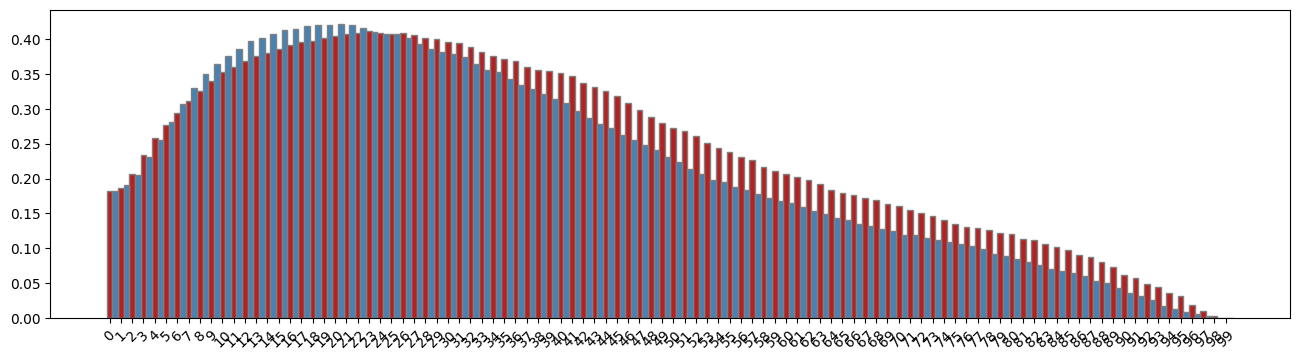

In [30]:
my_f1_scores = []
sb_f1_scores = []
for threshold in range(0, 100):
    gbt_pred = [math.ceil(x[1]-(threshold/100)) for x in gbt_xg]
    sb_pred = [math.ceil(x-(threshold/100)) for x in sb_xg]
    my_f1 = f1_score(y_test, gbt_pred)
    sb_f1 = f1_score(y_test, sb_pred)
    my_f1_scores.append(my_f1)
    sb_f1_scores.append(sb_f1)

barWidth = 0.5
r1 = np.arange(len(my_f1_scores))
r2 = [x + barWidth for x in r1]

plt.rcParams["font.size"] = 10
plt.rcParams["font.stretch"] = "semi-condensed"
plt.rcParams['grid.color'] = 'grey'

plt.figure(figsize=(16,4))
plt.bar(r1, pd.Series(my_f1_scores), color="firebrick", width=barWidth, edgecolor='grey', label='Our Prediction')
plt.bar(r2, pd.Series(sb_f1_scores), color="steelblue", width=barWidth, edgecolor='grey', label='SB Prediction')

plt.xticks(r1, [x for x in range(0, 100)], rotation=45)
plt.show()